In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\HP\AppData\Local\Temp\ipykernel_94432\2612871202.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = INTERVAL, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


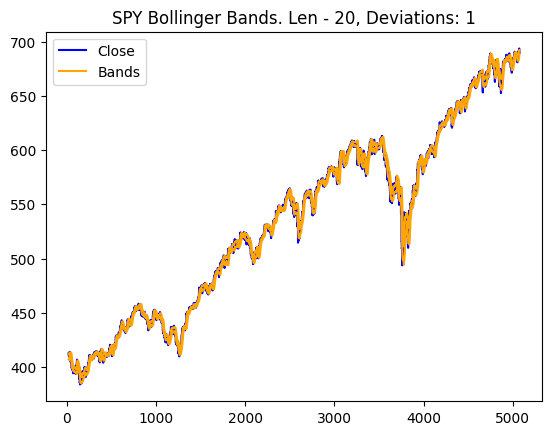

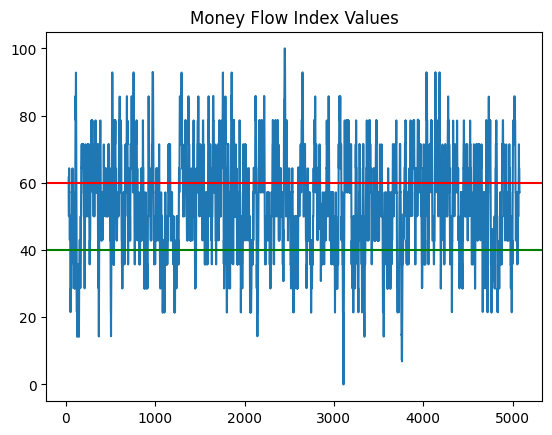

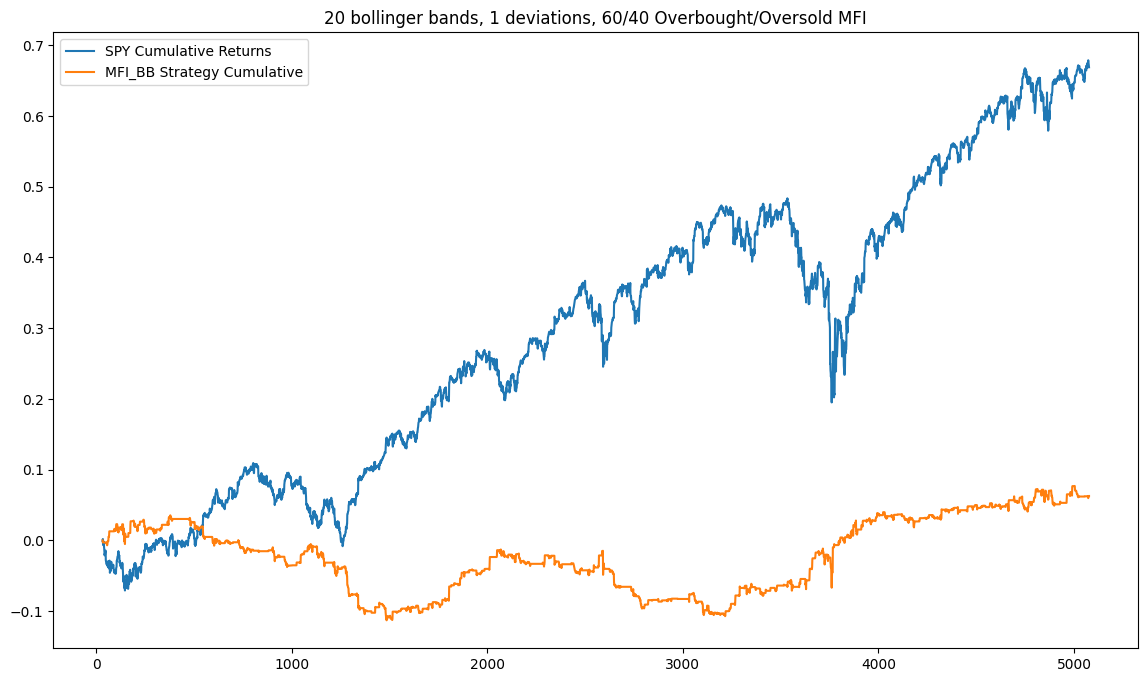

In [31]:
TICKER = 'SPY'
MFI_LENGTH = 14
MFI_OVERBOUGHT = 60
MFI_OVERSOLD = 40
LOOKBACK = 10000
INTERVAL = '1h'
BB_LEN = 20
DEVS = 1

#Set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

#what subsection of data are you interested in


def get_data(ticker = TICKER, lookback =  LOOKBACK, interval = INTERVAL):

    #get data at interval you want
    df = yf.download(ticker, interval = INTERVAL, period = PERIOD) 
    df.columns = df.columns.get_level_values(0)

    #reset the index to make plots prettier
    df = df.reset_index(drop = True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MFI(df, length = MFI_LENGTH, overbought = MFI_OVERBOUGHT, oversold = MFI_OVERSOLD):
    df['Average_Price'] = (df['High'] + df['Low'] + df['Close'])/3
    df['Money_Flow']= df['Volume'] * df['Average_Price']

        #Initialize empty flows
    df['Positive_Flow'] = 0
    df['Negative_Flow'] = 0

    df['Positive_Flow']= np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Negative_Flow']= np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    #money flow ratio
    mfr = df['Positive_Flow'].rolling(length).sum() /  df['Negative_Flow'].rolling(length).sum()

    #add money flow column
    df['MFI'] = 100 - (100 / (1 + mfr))
   

     #plot the Money Flow index
    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(overbought, color = 'red')
    plt.axhline(oversold, color = 'green')
    plt.title('Money Flow Index Values')
    
    return df.dropna()

def add_MFI_strategy(df, overbought = MFI_OVERBOUGHT, oversold= MFI_OVERSOLD):
    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1,
                     np.where(df['MFI'] < oversold, 1, 0))

    #shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)

    return df

def add_bollinger_bands(df, devs = DEVS, bb_len = BB_LEN):

    #can change to ema (use MACD video/ code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the periods
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color = 'blue')
    plt.plot(df['Upper_Band'], color = 'orange')
    plt.plot(df['Lower_Band'], color = 'orange')
    plt.legend(['Close', 'Bands'])
    plt.title(f'{TICKER} Bollinger Bands. Len - {BB_LEN}, Deviations: {devs}')

    return df.dropna()

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(df['Close'] > df['Upper_Band'], -1,
                        np.where(df['Close'] < df['Lower_Band'], 1, 0))
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)

    return df

def add_full_strategy(df):
    df['Full_Strategy'] = df['MFI_Strategy'] + df['BB_Strategy']
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1,
                     np.where(df['Full_Strategy'] == -2, -1, 0))
    
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_Returns'] = (1+ df['Close']. pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1+ df['Close']. pct_change() * df['Strategy']).cumprod() - 1
   

#plot the strategy returns
    plt.figure(figsize = (14,8))
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative Returns', 'MFI_BB Strategy Cumulative'])
    plt.title(f'{BB_LEN} bollinger bands, {DEVS} deviations, {MFI_OVERBOUGHT}/{MFI_OVERSOLD} Overbought/Oversold MFI')
    return df

def main():
    df = get_data(TICKER)
    df = add_bollinger_bands(df, devs = DEVS, bb_len = BB_LEN)
    df = add_MFI(df, length = MFI_LENGTH, overbought = MFI_OVERBOUGHT, oversold = MFI_OVERSOLD)
    df = add_MFI_strategy(df, overbought = MFI_OVERBOUGHT, oversold= MFI_OVERSOLD)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df
df = main()



In [26]:
df['Full_Strategy'].value_counts()

Full_Strategy
 0.0    2378
-2.0    2119
-1.0    1909
 1.0    1156
 2.0     697
Name: count, dtype: int64